In [2]:
from comet_ml import Experiment
experiment = Experiment(api_key="9V1gFeumyguS3tXr1fcTnoOAM", project_name="general", workspace="cottrell")

COMET ERROR: Failed to log git metadata
COMET ERROR: Failed to log git patch
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/cottrell/general/944ea9b8de334f559e2385df7e7f3319



In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
# https://stackoverflow.com/questions/44544766/how-do-i-check-if-keras-is-using-gpu-version-of-tensorflow
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# confirm PyTorch sees the GPU
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0
print(cuda.get_device_name(cuda.current_device()))

GeForce RTX 2070


Using TensorFlow backend.


In [5]:
# for some reason this breaks something when it runs first!?
import tensorflow as tf
print("cuda_only=False", tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))
print("cuda_only=True", tf.test.is_gpu_available(cuda_only=True, min_cuda_compute_capability=None))

cuda_only=False True
cuda_only=True True


In [6]:
%matplotlib inline
from pandas_datareader import data as pdr
import datetime
import fix_yahoo_finance as yf
from ratelimit import limits, sleep_and_retry
import sklearn.preprocessing as skp
from joblib import Memory
import os
import time
from pylab import *
_mydir = '.'

cachedir = os.path.join(_mydir, 'joblib_cache')
memory = Memory(cachedir, verbose=1)

yf.pdr_override()
_period_seconds = 1
@memory.cache
@sleep_and_retry
@limits(calls=1, period=_period_seconds)
def _get_data_yahoo(names, start, end):
    return pdr.get_data_yahoo(names, start=start, end=end)

def get_data_yahoo(names, start, end):
    df = _get_data_yahoo(names, start, end)
    if len(names) > 1:
        df = df.stack()
        df.index.names = ['date', 'name']
    else:
        df['name'] = names[0]
    df = df.reset_index()
    df.columns = [x.lower().replace(' ', '_') for x in df.columns]
    return df


names = ['soxx', 'spy', 'aapl', 'noc', 'gs']
start = datetime.date(2010, 1, 1)
end = datetime.date(2018, 11, 1)

data = get_data_yahoo(names, start, end)
data = data.sort_values(by='date')
data.shape

dates = data.date.unique()
dates.sort()
test_frac = 0.2
date_test = dates[int(len(dates) * (1 - test_frac))]
def split_data_by_date(data, date):
    i = data.date < date
    data_train = data[i]
    data_test = data[~i]
    print(data_train.shape, data_test.shape)
    return data_train, data_test

# one now for now
name = 'NOC'
data_train, data_test = split_data_by_date(data[data.name == name], date_test)

# do NO transformations for now, will be weird
xcols = ['adj_close', 'close', 'high', 'low', 'open', 'volume']
ycols = ['adj_close'] # shifted obviosly
pcols = ['adj_close', 'close', 'high', 'low', 'open']
output_dim = len(ycols)

def lagger(df, periods=[1]):
    d = list()
    for x in periods:
        temp = df.shift(periods=x)
        temp.columns = ['{}_lag{}'.format(k, x) for k in temp.columns] 
        d.append(temp)
    return pd.concat(d, axis=1)

d = lagger(data[xcols], periods=[1, 2, 3, 5, 10])

def getxy(data):
    assert data.name.nunique() == 1, 'you need to change the code if you do this'
    # watch out for overflow etc, TODO norm
    data = data.copy()
    data[pcols] = np.log(data[pcols]).diff()
    data = data.iloc[1:]
    
#     t = skp.QuantileTransformer(output_distribution='normal')
    t = skp.MinMaxScaler()
    
    t.fit(data[pcols])
    data[pcols] = t.transform(data[pcols])
    
    lags = [1, 2, 3, 5, 10]
    X = lagger(data[xcols], lags)
    X = pd.concat([data[xcols], X], axis=1).values

    predict_steps = 1
    y = data.shift(periods=-predict_steps)[ycols].values
    
    X = X[max(lags):-predict_steps]
    y = y[max(lags):-predict_steps]
    
    # add some lag features
    assert not np.any(np.isnan(X))
    assert not np.any(np.isnan(y))
    return X, y

X_train, y_train = getxy(data_train)
X_test, y_test = getxy(data_test)
X_train.shape, y_train.shape

input_dim = X_train.shape[1]

(1779, 8) (445, 8)


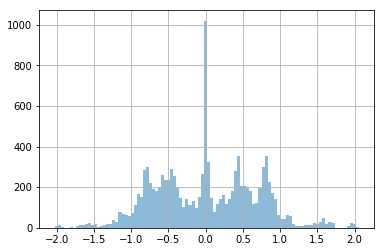

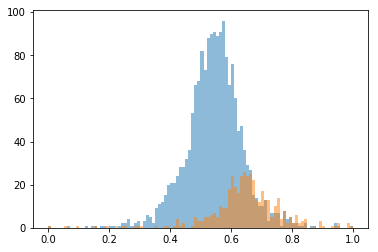

In [7]:
_ = np.log(data.adj_close).diff().dropna().hist(bins=100, alpha=0.5)

figure()
_ = hist(y_train, bins=100, alpha=0.5)
_ = hist(y_test, bins=100, alpha=0.5)


In [8]:
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.layers import Dense, Dropout
import tensorflow.keras.optimizers as optimizers
import tensorflow.layers as layers
import tensorflow as tf

# # https://stackoverflow.com/questions/47877475/keras-tensorboard-plot-train-and-validation-scalars-in-a-same-figure
# class TrainValTensorBoard(keras.callbacks.TensorBoard):
#     def __init__(self, log_dir='./logs', **kwargs):
#         # Make the original `TensorBoard` log to a subdirectory 'training'
#         training_log_dir = os.path.join(log_dir, 'training')
#         super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

#         # Log the validation metrics to a separate subdirectory
#         self.val_log_dir = os.path.join(log_dir, 'validation')

#     def set_model(self, model):
#         # Setup writer for validation metrics
#         self.val_writer = tf.summary.FileWriter(self.val_log_dir)
#         super(TrainValTensorBoard, self).set_model(model)

#     def on_epoch_end(self, epoch, logs=None):
#         # Pop the validation logs and handle them separately with
#         # `self.val_writer`. Also rename the keys so that they can
#         # be plotted on the same figure with the training metrics
#         logs = logs or {}
#         val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
#         for name, value in val_logs.items():
#             summary = tf.Summary()
#             summary_value = summary.value.add()
#             summary_value.simple_value = value.item()
#             summary_value.tag = name
#             self.val_writer.add_summary(summary, epoch)
#         self.val_writer.flush()

#         # Pass the remaining logs to `TensorBoard.on_epoch_end`
#         logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
#         super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

#     def on_train_end(self, logs=None):
#         super(TrainValTensorBoard, self).on_train_end(logs)
#         self.val_writer.close()
        
tboard = keras.callbacks.TensorBoard(log_dir="runs/keras-{}".format(time.time()))
# tensorboard = TrainValTensorBoard(log_dir="runs/keras-{}".format(time.time()), write_graph=False)

In [9]:
# for example https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

def create_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, kernel_initializer='normal', activation='relu')),
    model.add(Dense(32, input_dim=input_dim, kernel_initializer='normal', activation='relu')),
    model.add(Dense(output_dim, kernel_initializer='normal'))
    opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

model = create_model()

In [10]:
# fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None,
# validation_split=0.0, validation_data=None, shuffle=True, class_weight=None,
# sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None,
# max_queue_size=10, workers=1, use_multiprocessing=False, **kwargs)
model.fit(X_train, y_train.squeeze(), epochs=20, steps_per_epoch=100, verbose=1, validation_steps=100, validation_data=(X_test, y_test.squeeze()), callbacks=[tboard])

Epoch 1/20
100/100 [==============================] - 0s 4ms/step - loss: 45518420.6025 - val_loss: 1851191.0000
Epoch 2/20
100/100 [==============================] - 0s 2ms/step - loss: 1675337.0903 - val_loss: 226585.2812
Epoch 3/20
100/100 [==============================] - 0s 2ms/step - loss: 271966.3914 - val_loss: 100624.3516
Epoch 4/20
100/100 [==============================] - 0s 2ms/step - loss: 172372.7233 - val_loss: 74573.8828
Epoch 5/20
100/100 [==============================] - 0s 2ms/step - loss: 123427.0864 - val_loss: 56046.2812
Epoch 6/20
100/100 [==============================] - 0s 2ms/step - loss: 84952.7188 - val_loss: 34290.9961
Epoch 7/20
100/100 [==============================] - 0s 2ms/step - loss: 59884.1410 - val_loss: 26369.7988
Epoch 8/20
100/100 [==============================] - 0s 2ms/step - loss: 45268.6475 - val_loss: 20850.2051
Epoch 9/20
100/100 [==============================] - 0s 2ms/step - loss: 35185.0824 - val_loss: 16789.1816
Epoch 10/20
100/

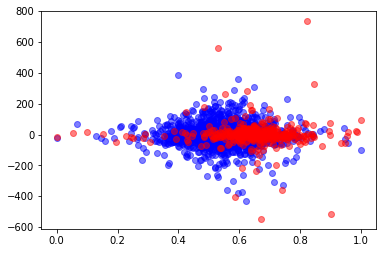

In [51]:
plot(y_train.squeeze(), model.predict(X_train).squeeze(), 'bo', alpha=0.5)
plot(y_test.squeeze(), model.predict(X_test).squeeze(), 'ro', alpha=0.5)
# xlim(min(y_test), max(y_test))
# ylim(min(y_test), max(y_test))



In [50]:
model.predict(X_train).squeeze().tolist()

[5.562430381774902,
 -20.28986358642578,
 -81.95368194580078,
 9.699393272399902,
 53.82610321044922,
 6.622488975524902,
 47.58928680419922,
 -11.541085243225098,
 50.56291961669922,
 -52.77204132080078,
 85.42668914794922,
 138.8126678466797,
 159.0048065185547,
 -61.49030303955078,
 30.29387664794922,
 55.87248992919922,
 22.36907196044922,
 -26.31256866455078,
 -34.94928741455078,
 31.20842742919922,
 33.96379852294922,
 -99.11090850830078,
 -113.86042022705078,
 123.66448211669922,
 37.30266571044922,
 34.42961883544922,
 -167.9004669189453,
 42.98088836669922,
 -4.583565711975098,
 -57.64118194580078,
 -68.68805694580078,
 -87.49469757080078,
 -55.89118194580078,
 91.87786102294922,
 -10.091622352600098,
 -46.03864288330078,
 -42.10431671142578,
 -34.24738311767578,
 11.940848350524902,
 -25.37580108642578,
 -72.58234405517578,
 -5.994698524475098,
 63.99260711669922,
 -19.07013702392578,
 132.4091033935547,
 -16.26178741455078,
 -8.116280555725098,
 -5.183907508850098,
 -57.3958

In [53]:
model.set_weights?